In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
from pyinstrument import Profiler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import os
sys.path.append(os.path.dirname(os.getcwd()))
from bart_playground import *

import bartz

## 4 Special Moves

In [2]:
proposal_probs = {"grow" : 0.5, "prune" : 0.5}
special_probs = {"birth": 0.25, "death": 0.25, "break": 0.25, "combine": 0.25}
generator = DataGenerator(n_samples=160, n_features=2, noise=0.1, random_seed=42)
X, y = generator.generate(scenario="piecewise_flat")
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

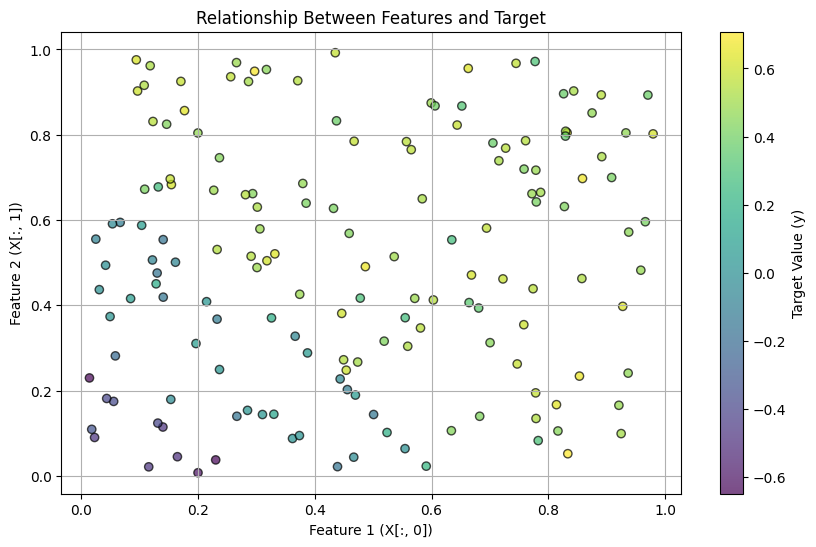

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', edgecolor='k', alpha=0.7)
plt.colorbar(scatter, label='Target Value (y)')
plt.title('Relationship Between Features and Target')
plt.xlabel('Feature 1 (X[:, 0])')
plt.ylabel('Feature 2 (X[:, 1])')
plt.grid(True)
plt.show()

In [4]:
bart = ChangeNumTreeBART(ndpost=1000, nskip=1000, n_trees=100, 
                         proposal_probs=proposal_probs, special_probs = special_probs, 
                         theta_0 = 100, theta_df = np.inf, 
                         tree_num_prior_type="poisson")
bart.fit(X_train, y_train)

Iterations: 100%|██████████| 2000/2000 [00:18<00:00, 105.50it/s]


In [5]:
bart.trace[-1].n_trees

40

In [6]:
bart.trace[-1].global_params

{'eps_sigma2': array([0.00357297]), 'ntree_theta': 100}

In [7]:
# Extract the n_trees value for each instance
n_trees_list = [instance.n_trees for instance in bart.trace]
np.mean(n_trees_list)

50.611

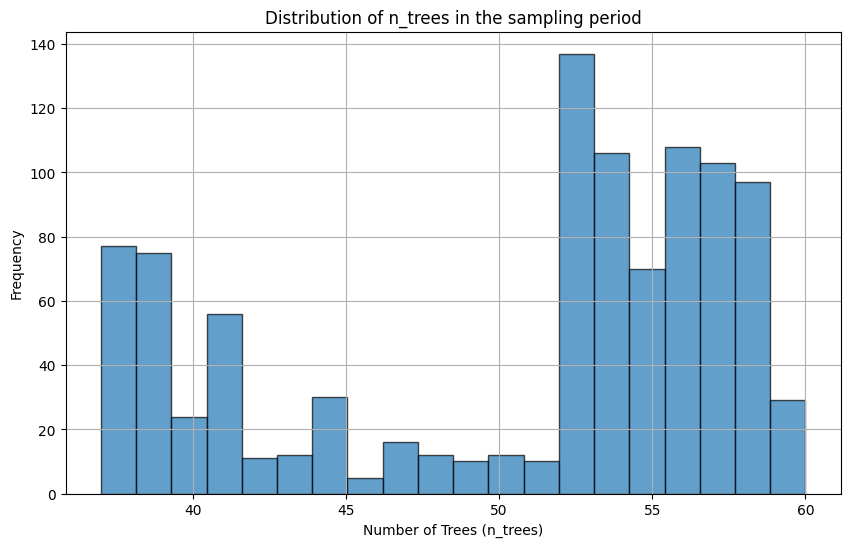

In [8]:
# Create a histogram with bins for each integer value
plt.figure(figsize=(10, 6))
plt.hist(n_trees_list, bins=20, edgecolor='k', alpha=0.7)
plt.title('Distribution of n_trees in the sampling period')
plt.xlabel('Number of Trees (n_trees)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

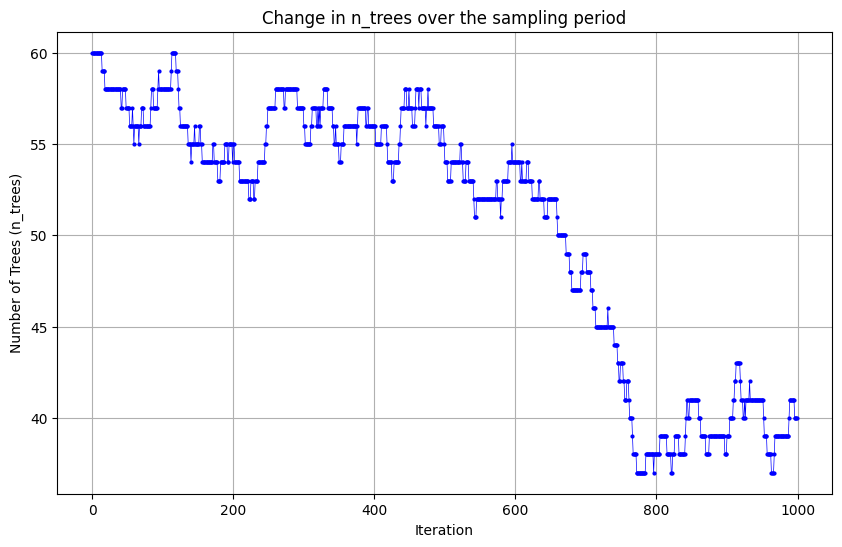

In [9]:
# Create a line plot
plt.figure(figsize=(10, 6))
plt.plot(
    range(len(n_trees_list)), 
    n_trees_list, 
    marker='o', 
    markersize=2,  # Adjust marker size
    linestyle='-', 
    linewidth=0.5,  # Adjust line width
    color='b'
)
plt.title('Change in n_trees over the sampling period')
plt.xlabel('Iteration')
plt.ylabel('Number of Trees (n_trees)')
plt.grid(True)
plt.show()

In [10]:
ntree = bart.trace[-1].n_trees
rf = RandomForestRegressor(n_estimators=ntree)
lr = LinearRegression()
rf.fit(X_train, y_train)
lr.fit(X_train, y_train)

btz = bartz.BART.gbart(np.transpose(X_train), y_train, ntree=ntree, ndpost=200, nskip=100)
btpred_all = btz.predict(np.transpose(X_test))
btpred = np.mean(np.array(btpred_all), axis=0)

INFO:2025-04-15 01:34:19,068:jax._src.xla_bridge:927: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:2025-04-15 01:34:19,072:jax._src.xla_bridge:927: Unable to initialize backend 'tpu': UNIMPLEMENTED: LoadPjrtPlugin is not implemented on windows yet.
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': UNIMPLEMENTED: LoadPjrtPlugin is not implemented on windows yet.


Iteration 100/300 P_grow=0.57 P_prune=0.43 A_grow=0.35 A_prune=0.41 (burnin)
Iteration 200/300 P_grow=0.62 P_prune=0.38 A_grow=0.52 A_prune=0.47
Iteration 300/300 P_grow=0.43 P_prune=0.57 A_grow=0.12 A_prune=0.30


In [11]:
models = {"bart" : bart, 
          "rf" : rf, 
          "lr" : lr,
          "btz" : btz}
results = {}
for model_name, model in models.items():
    if model_name == "btz":
        results[model_name] = mean_squared_error(y_test, btpred)
    else:
        results[model_name] = mean_squared_error(y_test, model.predict(X_test))
results

{'bart': 0.18910902869111007,
 'rf': 0.02256195386220044,
 'lr': 0.048045521328019404,
 'btz': 0.02451239499995969}

In [12]:
bart.trace[-1].trees

[Tree(vars=[ 0  1 -1 -1 -1 -2 -2 -2], thresholds=[0.11667251 0.68261773        nan        nan        nan        nan
         nan        nan], leaf_vals=[        nan         nan -0.00361689 -0.03538036 -0.06997509         nan
          nan         nan], n_vals=[120  16 104  14   2  -2  -2  -2]),
 Tree(vars=[ 0 -1 -1 -2], thresholds=[0.75827773        nan        nan        nan], leaf_vals=[        nan -0.01618338 -0.00070899         nan], n_vals=[120  91  29  -2]),
 Tree(vars=[ 0 -1 -1 -2], thresholds=[0.11051175        nan        nan        nan], leaf_vals=[        nan  0.03129057 -0.02994409         nan], n_vals=[120  15 105  -2]),
 Tree(vars=[-1 -2], thresholds=[nan nan], leaf_vals=[-0.04905049         nan], n_vals=[120  -2]),
 Tree(vars=[ 0  1 -1 -1 -1 -2 -2 -2], thresholds=[0.37508165 0.70812683        nan        nan        nan        nan
         nan        nan], leaf_vals=[        nan         nan  0.02998829  0.03555261 -0.0196794          nan
          nan         nan], n_vals=[1

In [13]:
X_sample = X_test[0].reshape(1, -1)
X_sample

array([[0.69426244, 0.58111661]])

In [14]:
y_test[0]

0.574943389972774

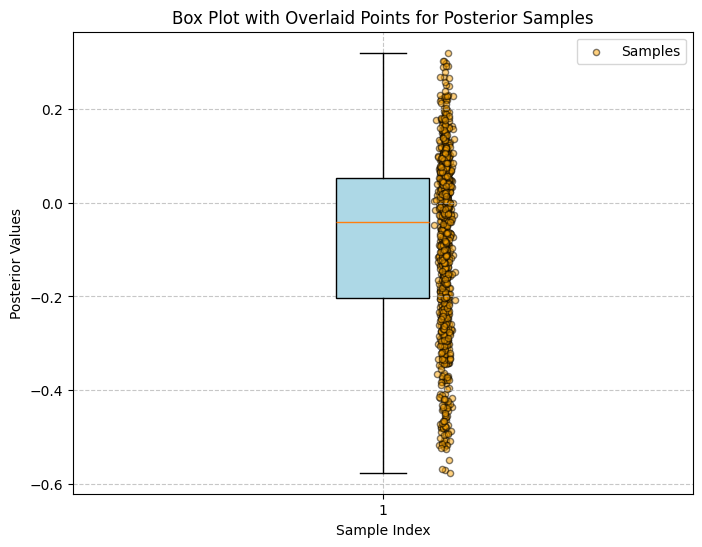

In [15]:
import matplotlib.pyplot as plt
import numpy as np

posterior_values = bart.posterior_f(X_sample)

plt.figure(figsize=(8, 6))
plt.boxplot(posterior_values[0], vert=True, patch_artist=True, boxprops=dict(facecolor='lightblue'))
for i in range(posterior_values.shape[1]):
    y = posterior_values[:, i]
    x = np.random.normal(1.1, 0.005, size=len(y))
    plt.scatter(x, y, alpha=0.5, color='orange', edgecolor='k', s=20, label='Samples' if i == 0 else None)

plt.title('Box Plot with Overlaid Points for Posterior Samples')
plt.ylabel('Posterior Values')
plt.xlabel('Sample Index')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

In [16]:
eval_single = [float(bart.trace[0].trees[i].evaluate(X_sample)) for i in range(len(bart.trace[0].trees))]
eval_single

[0.031164803515296755,
 0.015149207693754788,
 -0.026238620782840928,
 -0.03031910374707849,
 -0.07836509909373642,
 -0.05310861625368857,
 -0.03367724935795181,
 0.022735184289063633,
 0.045422275227857335,
 0.03506374687483688,
 -0.05630501298458319,
 0.039341420225909224,
 0.012262666097855953,
 0.017354880824267956,
 -0.047913490463494926,
 -0.0010799886517496513,
 0.017027185550805943,
 -0.015261860967676679,
 -0.07404922027929307,
 0.03636870353388177,
 0.05614640374475659,
 -0.00202859990795238,
 -0.029705695999600053,
 0.057779589388818414,
 0.024485087447563048,
 -0.03886252479922183,
 -0.04525567404630917,
 -0.04409137777039089,
 0.009875993800258998,
 0.02033819007933784,
 -0.02060296508246417,
 0.021104796837783955,
 -0.001484263524347218,
 -0.024586788537873987,
 -0.008763092278635618,
 -0.01510262681163427,
 -0.04078662470479055,
 0.007176103487237255,
 -0.012800133505917513,
 0.02729327962875145,
 -0.014298638354608088,
 0.0035480522474480567,
 -0.013657743122300564,
 0.

In [17]:
len(eval_single)

60

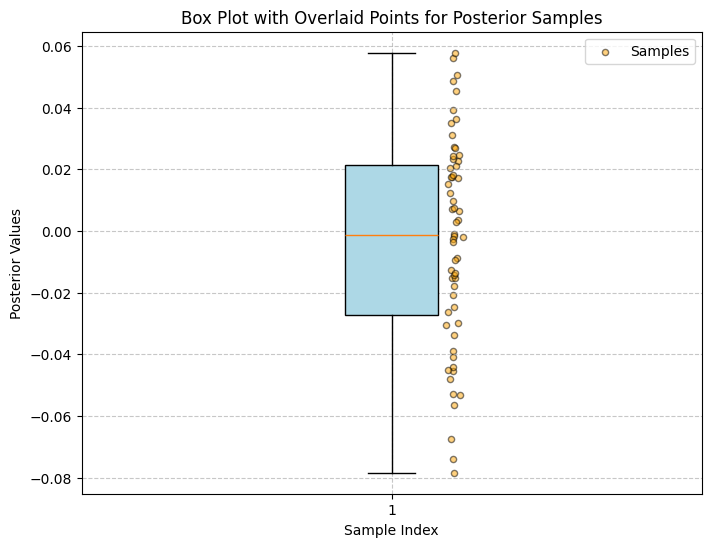

In [18]:
plt.figure(figsize=(8, 6))
plt.boxplot(eval_single, vert=True, patch_artist=True, boxprops=dict(facecolor='lightblue'))
for i in range(len(eval_single)):
    y = eval_single[i]
    x = np.random.normal(1.1, 0.005, size=1)
    plt.scatter(x, y, alpha=0.5, color='orange', edgecolor='k', s=20, label='Samples' if i == 0 else None)

plt.title('Box Plot with Overlaid Points for Posterior Samples')
plt.ylabel('Posterior Values')
plt.xlabel('Sample Index')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

In [19]:
np.sum(eval_single)

-0.20151557668267117

In [20]:
eval = [bart.trace[i].evaluate(X_sample) for i in range(len(bart.trace))]
eval

[array([-0.20151558]),
 array([-0.18923004]),
 array([-0.16258768]),
 array([-0.12566226]),
 array([-0.11825863]),
 array([-0.16781996]),
 array([-0.18876208]),
 array([-0.19797627]),
 array([-0.19411943]),
 array([-0.18101281]),
 array([-0.20122178]),
 array([-0.19751848]),
 array([-0.2135814]),
 array([-0.19355976]),
 array([-0.20453935]),
 array([-0.16737458]),
 array([-0.18059201]),
 array([-0.21226592]),
 array([-0.22407394]),
 array([-0.17014918]),
 array([-0.17240464]),
 array([-0.18115603]),
 array([-0.27350978]),
 array([-0.26417793]),
 array([-0.29274598]),
 array([-0.31332549]),
 array([-0.27973077]),
 array([-0.29763373]),
 array([-0.33698829]),
 array([-0.2777953]),
 array([-0.27409789]),
 array([-0.23681551]),
 array([-0.25288738]),
 array([-0.23770708]),
 array([-0.27246877]),
 array([-0.29437223]),
 array([-0.24628546]),
 array([-0.22189118]),
 array([-0.30578126]),
 array([-0.29033441]),
 array([-0.24453074]),
 array([-0.18051911]),
 array([-0.22353434]),
 array([-0.23

In [21]:
y_test

array([ 0.57494339, -0.39107825,  0.03833771, -0.10585361,  0.58205285,
       -0.46879905, -0.12964723,  0.48524713,  0.30069396,  0.48688625,
        0.49330468,  0.4528224 ,  0.5750869 ,  0.55541165,  0.43010696,
        0.6155312 ,  0.44660998,  0.51601906,  0.48824578,  0.18206462,
        0.37483528, -0.15720403,  0.57823503,  0.43025762,  0.56087615,
        0.49741372, -0.02658388,  0.4874991 ,  0.04278904, -0.06782644,
       -0.03427862,  0.54396366,  0.52023062, -0.14805365,  0.61774119,
        0.54746971,  0.58137637, -0.46316434,  0.29964777,  0.55300647])

In [22]:
btpred

array([ 0.358217  , -0.32099652, -0.17386234,  0.22109725,  0.5639452 ,
       -0.3306616 ,  0.22483106,  0.57108885,  0.5521071 ,  0.4276291 ,
        0.37939852,  0.6438375 ,  0.5511137 ,  0.39661777,  0.36955607,
        0.47481826,  0.55624396,  0.539176  ,  0.45390236,  0.32189468,
        0.5374934 ,  0.10398027,  0.50345945,  0.5017972 ,  0.4657312 ,
        0.52921295, -0.30379972,  0.39619333,  0.03462169,  0.16736807,
        0.02196804,  0.4915038 ,  0.37647   ,  0.03904977,  0.5130085 ,
        0.4129956 ,  0.39325845, -0.43244728,  0.49828538,  0.4975007 ],
      dtype=float32)

In [23]:
y_pred = bart.predict(X_test)
y_pred

array([-0.07868952, -0.0080201 ,  0.13154349, -0.00688937,  0.03417987,
       -0.01908793, -0.04927729,  0.14502645, -0.03387271, -0.02647386,
        0.15832041,  0.14077659, -0.00422031, -0.02807766, -0.11985455,
       -0.0355097 , -0.01886158, -0.05005937, -0.0279266 ,  0.09769062,
       -0.05382196,  0.08583661, -0.01510787, -0.04792772,  0.03410172,
        0.02751958,  0.03458748,  0.08665763,  0.02425102,  0.08083554,
        0.08269549,  0.13488923, -0.0117549 ,  0.0708614 ,  0.12466215,
       -0.04104983,  0.12964575, -0.00770833, -0.00736437, -0.10526742])